## Stroke Work
Author: Daniel Maina Nderitu<br>
Project: MADIVA<br>
Purpose: Explainability<br>
Notes:  Which variables are driving stroke risk predictions in our model?

#### Bootstrap cell

In [42]:
# =================== BOOTSTRAP CELL ===================
# Standard setup for all notebooks
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import shap
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from src.utils.helpers import shap_dependence_safe
from src.config.variables import COVARIATES

# ========================================================
# Optional for warnings and nicer plots
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

import sys
from pathlib import Path

# ========================================================
# Project root
PROJECT_ROOT = Path.cwd().parents[0]  
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
# Helper to load paths
from src.utils.helpers import load_paths

# ========================================================
# Load paths from config.yaml
paths = load_paths()

# ========================================================
# Printing paths to confirm
for key, value in paths.items():
    print(f"{key}: {value}")

# ========================================================
# Paths in our notebook:
DATA_DIR = paths['DATA_DIR']
OUT_DIR = paths['OUT_DIR']
FIG_DIR = paths['FIG_DIR']
MODEL_DIR = paths['MODEL_DIR']

SHAP_DIR = FIG_DIR / "shap"
SHAP_DIR.mkdir(exist_ok=True)
# ========================================================

BASE_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work
DATA_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\data
OUT_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output
FIG_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\visualization
MODEL_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output\statsmodels
NOTEBOOKS_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks
NOTEBOOKS_EXECUTED_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks_executed


### Import data - from previous step

In [43]:
# -----------------------------------------------------------------------------
# Loading saved data as pickle:
# -----------------------------------------------------------------------------
df = pd.read_pickle(OUT_DIR / "df_step07_ii_processed.pkl")
X = pd.read_pickle(OUT_DIR / "X_step07_ii_model_matrix.pkl")
y = pd.read_pickle(OUT_DIR / "y_step07_ii_event.pkl")
study_periods = pd.read_pickle(OUT_DIR / "study_periods.pkl")

results_pois = pd.read_pickle(OUT_DIR / "results_pois.pkl")
results_robust = pd.read_pickle(OUT_DIR / "results_robust.pkl")
results_nb = pd.read_pickle(OUT_DIR / "results_nb.pkl")
all_results = pd.read_pickle(OUT_DIR / "df_step07_all_results.pkl")

# -----------------------------------------------------------------------------
# Loading saved models as pickle:
# -----------------------------------------------------------------------------
import pickle

with open(MODEL_DIR / "model_pois.pkl", "rb") as f:
    model_pois = pickle.load(f)

with open(MODEL_DIR / "model_nb.pkl", "rb") as f:
    model_nb = pickle.load(f)

with open(MODEL_DIR / "rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

with open(MODEL_DIR / "xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open(MODEL_DIR / "lgb_model.pkl", "rb") as f:
    lgb_model = pickle.load(f)


#### Building SHAP explainer

In [44]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

#### Global importance plot

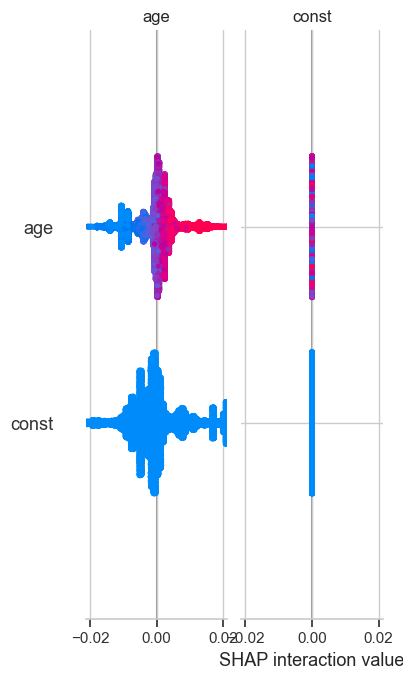

In [45]:
shap.summary_plot(shap_values, X, show=False)
plt.savefig(SHAP_DIR / "shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()

In [46]:
# Replacing 999 with NaN
X_shap = X.copy()
X_shap['hpt_status_derived'] = X_shap['hpt_status_derived'].replace(999, np.nan)

# Dropping rows with NaN for SHAP plotting
X_shap = X_shap.dropna(subset=['hpt_status_derived'])
X_shap.shape

(28591, 11)

In [47]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

In [48]:
print("X_shap shape:", X_shap.shape)
print("shap_values shape:", shap_values.shape)

X_shap shape: (28591, 11)
shap_values shape: (28591, 11, 2)


In [49]:
mask = X_shap['hpt_status_derived'].notna()
X_shap_clean = X_shap[mask]
shap_values_clean = shap_values[mask, :]  # keep all columns

shap.dependence_plot(
    "hpt_status_derived",
    shap_values_clean,
    X_shap_clean,
    show=False
)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

#### Here

In [37]:
# Dropping rows with NaN in my important feature
X_shap_clean = X_shap.dropna(
    subset=['hpt_status_derived']).reset_index(drop=True
                                              )

# Recomputing shap_values on clean X
shap_values_clean = explainer.shap_values(X_shap_clean)

# plotting
shap.dependence_plot(
    'hpt_status_derived', 
    shap_values_clean, 
    X_shap, 
    show=False)
plt.savefig(SHAP_DIR / "shap_dependence_hpt_status_derived.png", dpi=300, bbox_inches="tight")
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

In [25]:
# rows we want to keep
keep_idx = X_shap.dropna(subset=['hpt_status_derived']).index

# Converting to integer positions (0-based)
pos_idx = [X_shap.index.get_loc(i) for i in keep_idx]

# Subsetting shap_values
shap_values_clean = shap_values[pos_idx, :]

# Subsetting X
X_shap_clean = X_shap.loc[keep_idx]

shap.dependence_plot(
    'hpt_status_derived',  
    shap_values,           
    X_shap,                
    show=False
)

plt.savefig(SHAP_DIR / "shap_dependence_hpt_status_derived.png", dpi=300, bbox_inches="tight")
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.dependence_plot(
    "hpt_status_derived",   # your cleaned variable
    shap_values_clean,
    X_shap,
    show=False
)

plt.savefig(SHAP_DIR / "shap_dependence_hpt_status.png", dpi=300, bbox_inches="tight")
plt.show()

#### xxx

#### Individual explanation - xxx

In [5]:
# Hypertension status
shap_dependence_safe(
    "hpt_status_derived",
    shap_values,
    X,
    SHAP_DIR
)

# Age
shap_dependence_safe(
    "age",
    shap_values,
    X,
    SHAP_DIR
)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

#### Grouped IRR plots

#### End

In [ ]:
# Saved as pickle (faster for large data, preserves types)
df.to_pickle(OUT_DIR / "df_step08_processed.pkl")